In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from PIL import Image
from tqdm import tqdm

In [2]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## test 폴더 내 1 이미지 좌우반전 후 train, test로 분리

In [3]:
'''
# train 좌우반전하여 이미지 추가 생성

for i in range(tmp_train_df.shape[0]):
  img_path = tmp_train_df['img_path'].iloc[i]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))
  cv2.imwrite('./train/TRAIN_'+str(213 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
'''

"\n# train 좌우반전하여 이미지 추가 생성\n\nfor i in range(tmp_train_df.shape[0]):\n  img_path = tmp_train_df['img_path'].iloc[i]\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))\n  cv2.imwrite('./train/TRAIN_'+str(213 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\n"

In [4]:
%cd C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data

C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data


In [5]:
#train 폴더 내 정상 데이터 모두 가져오기
from glob import glob

tmp_train = glob("./train/*.png")
tmp_train = [path.replace('\\', '/') for path in tmp_train]
tmp_train_df = pd.DataFrame({'id': [i.split('/')[2].split('.')[0] for i in tmp_train], 
                             'img_path': tmp_train, 'label': 0}).sort_values(by='img_path', ignore_index=True)

tmp_train_df.tail()

,id,img_path,label
421,TRAIN_421,./train/TRAIN_421.png,0
422,TRAIN_422,./train/TRAIN_422.png,0
423,TRAIN_423,./train/TRAIN_423.png,0
424,TRAIN_424,./train/TRAIN_424.png,0
425,TRAIN_425,./train/TRAIN_425.png,0


In [6]:
# test 폴더 내 정상 데이터 모두 가져오기
tmp_test_df = pd.read_csv('./test_label.csv')
tmp_test_df_all_true = tmp_test_df[tmp_test_df['label'] == 0].reset_index(drop=True)
tmp_test_df_all_true.tail()

,id,img_path,label
56,TEST_084,./test/TEST_084.png,0
57,TEST_087,./test/TEST_087.png,0
58,TEST_089,./test/TEST_089.png,0
59,TEST_096,./test/TEST_096.png,0
60,TEST_097,./test/TEST_097.png,0


In [7]:
# 좌우반전하여 이미지 추가 생성
tmp_df = pd.read_csv('./test_label.csv')
tmp_df_all_false = tmp_test_df[tmp_test_df['label'] == 1].reset_index(drop=True)
tmp_df_all_false.tail()

,id,img_path,label
34,TEST_093,./test/TEST_093.png,1
35,TEST_094,./test/TEST_094.png,1
36,TEST_095,./test/TEST_095.png,1
37,TEST_098,./test/TEST_098.png,1
38,TEST_099,./test/TEST_099.png,1


In [8]:
len(tmp_df_all_false)

39

In [9]:
'''
# test의 1(불량) 이미지 좌우반전을 통해 추가 생성
for i in range(tmp_df_all_false.shape[0]):
  img_path = tmp_df_all_false['img_path'].iloc[i]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))
  cv2.imwrite('./test/TEST_'+str(100 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
'''

"\n# test의 1(불량) 이미지 좌우반전을 통해 추가 생성\nfor i in range(tmp_df_all_false.shape[0]):\n  img_path = tmp_df_all_false['img_path'].iloc[i]\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))\n  cv2.imwrite('./test/TEST_'+str(100 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\n"

In [10]:
# 좌우반전된 비정상 데이터만 모두 가져오기
tmp_test = glob("./test/*.png")[100:]
tmp_test = [path.replace('\\', '/') for path in tmp_test]
tmp_test_df = pd.DataFrame({'id' : [i.split('/')[2].split('.')[0] for i in tmp_test] , 
                            'img_path' : tmp_test, 'label' : 1}).sort_values(by='img_path', ignore_index=True)
tmp_test_df.tail()

,id,img_path,label
34,TEST_134,./test/TEST_134.png,1
35,TEST_135,./test/TEST_135.png,1
36,TEST_136,./test/TEST_136.png,1
37,TEST_137,./test/TEST_137.png,1
38,TEST_138,./test/TEST_138.png,1


In [11]:
tmp_test_df.shape

(39, 3)

In [12]:
# 테스트 폴더 내 비정상 데이터들만 합치기
tmp_test_df_all_false = pd.concat([tmp_df_all_false, tmp_test_df], axis=0, sort=True).reset_index(drop=True)
tmp_test_df_all_false = tmp_test_df_all_false.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
tmp_test_df_all_false.tail()

,id,img_path,label
73,TEST_130,./test/TEST_130.png,1
74,TEST_069,./test/TEST_069.png,1
75,TEST_044,./test/TEST_044.png,1
76,TEST_030,./test/TEST_030.png,1
77,TEST_104,./test/TEST_104.png,1


In [13]:
# train 폴더 내 정상 이미지
print('train 폴더 내 정상 이미지: ', tmp_train_df.shape)

# test 폴더 내 정상 이미지
print('test 폴더 내 정상 이미지: ', tmp_test_df_all_true.shape)

# test 폴더 내 불량 이미지
print('test 폴더 내 불량 이미지: ', tmp_test_df_all_false.shape)


train 폴더 내 정상 이미지:  (426, 3)
test 폴더 내 정상 이미지:  (61, 3)
test 폴더 내 불량 이미지:  (78, 3)


In [14]:
# train 폴더에 test 1 이미지 분배(5:5 -> 0~39)
train_df = pd.concat([tmp_train_df, tmp_test_df_all_false[:39]], axis=0)
train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset 
                                                           # sample(frac=1) : 데이터프레임의 모든 행을 포함하도록 하여 데이터를 완전히 섞는 것
train_df

,id,img_path,label
0,TRAIN_039,./train/TRAIN_039.png,0
1,TRAIN_108,./train/TRAIN_108.png,0
2,TRAIN_239,./train/TRAIN_239.png,0
3,TRAIN_128,./train/TRAIN_128.png,0
4,TRAIN_348,./train/TRAIN_348.png,0
...,...,...,...
460,TRAIN_163,./train/TRAIN_163.png,0
461,TRAIN_406,./train/TRAIN_406.png,0
462,TEST_095,./test/TEST_095.png,1
463,TRAIN_303,./train/TRAIN_303.png,0


In [15]:
# test 폴더에 test 1 이미지 분배(5:5 -> 39 이후 부터 마지막까지)
test_df = pd.concat([tmp_test_df_all_true, tmp_test_df_all_false[-39:]], axis=0)
test_df = test_df.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset 
                                                         # sample(frac=1) : 데이터프레임의 모든 행을 포함하도록 하여 데이터를 완전히 섞는 것
test_df

,id,img_path,label
0,TEST_079,./test/TEST_079.png,1
1,TEST_031,./test/TEST_031.png,1
2,TEST_061,./test/TEST_061.png,0
3,TEST_084,./test/TEST_084.png,0
4,TEST_113,./test/TEST_113.png,1
...,...,...,...
95,TEST_019,./test/TEST_019.png,0
96,TEST_042,./test/TEST_042.png,0
97,TEST_121,./test/TEST_121.png,1
98,TEST_001,./test/TEST_001.png,1


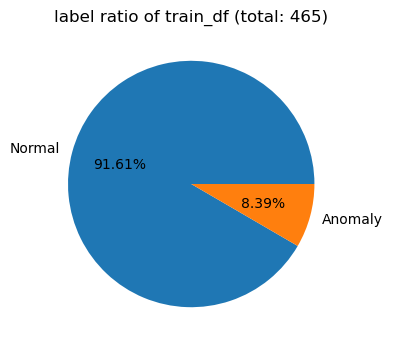

In [16]:
# train 폴더 내 label 비중
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(4, 4))
test_label = train_df.groupby('label').count()
plt.pie(test_label['id'], labels= labels, autopct='%1.2f%%')
plt.title('label ratio of train_df (total: 465)')
plt.show()

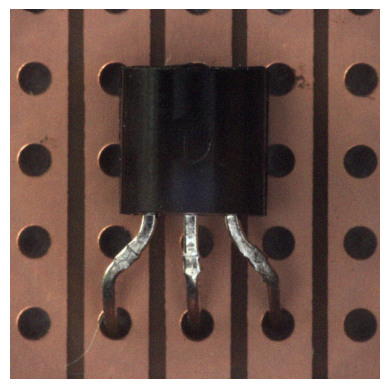

In [17]:
# 이미지 읽기
image = cv2.imread(train_df['img_path'][0])

# BGR에서 RGB로 색 공간 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.imshow(image_rgb)
plt.axis('off')  # 축 제거
plt.show()

In [18]:
def image_array(df):
      img_path = df['img_path']
      img_list = []
      for i in img_path:
        image = cv2.imread(i)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지를 RGB 형태로 변환
        image = image.reshape(512*512*3)   # oversampling 위해 1차원 배열로 평탄화
        img_list.append(image)

      return img_list

In [19]:
train_df_arrays = image_array(train_df)
len(train_df_arrays)

465

In [20]:
train_df_arrays[0].shape

(786432,)

In [21]:
# train df 속 1 데이터 증강
# 그냥 이미지 데이터 자체로서 oversampling 한 경우

# SMOTE 적용
from imblearn.over_sampling import SMOTE
X_train = train_df_arrays
y_train = train_df['label']

smote = SMOTE(random_state=13)
# 트레인만 oversampling
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 얼마나 늘어났는지 확인
len(X_train), len(y_train), len(X_train_over), len(y_train_over)

(465, 465, 852, 852)

(512, 512, 3) <class 'numpy.ndarray'>


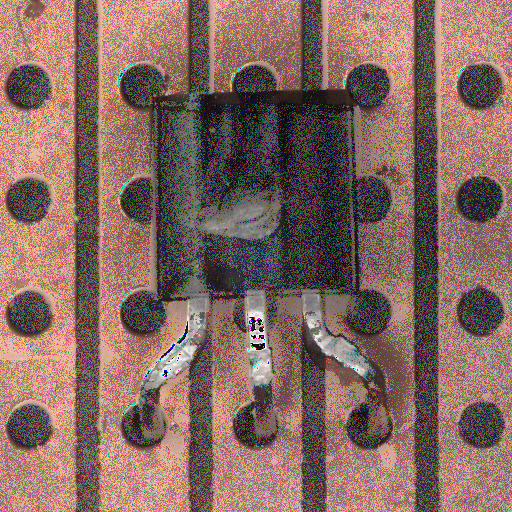

In [22]:
img = np.array(X_train_over[800]).reshape(512, 512, 3)
print(img.shape, type(img))
Image.fromarray(img.astype(np.uint8))


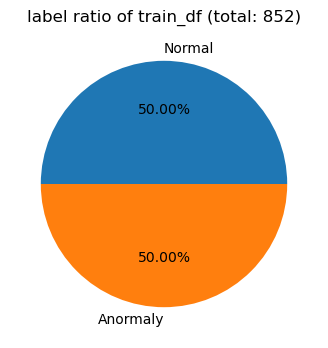

In [23]:
# 증강 후 train 폴더 내 label 비중
labels = ['Normal', 'Anormaly']
plt.figure(figsize=(4, 4))
test_label = [len(X_train_over), len(y_train_over)]
plt.pie(test_label, labels= labels, autopct='%1.2f%%')
plt.title('label ratio of train_df (total: {})'.format(len(y_train_over)))
plt.show()

In [24]:
X_train[0]

array([139,  82,  92, ..., 139,  93,  90], dtype=uint8)

(512, 512, 3) <class 'numpy.ndarray'>


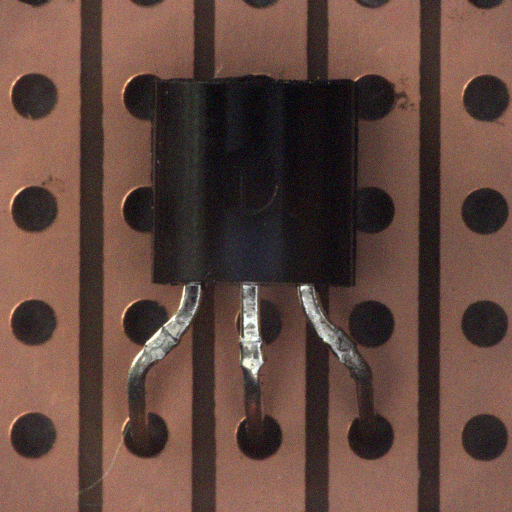

In [25]:
img = np.array(X_train_over[0]).reshape(512, 512, 3)
print(img.shape, type(img))
Image.fromarray(img.astype(np.uint8))

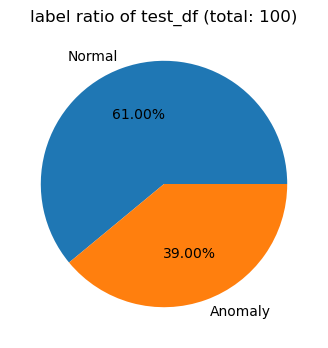

In [26]:
# test 폴더 내 label 비중
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(4, 4))
test_label = test_df.groupby('label').count()
plt.pie(test_label['id'], labels= labels, autopct='%1.2f%%')
plt.title('label ratio of test_df (total: 100)')
plt.show()

## 데이터 로더로 이미지 불러오기

In [29]:
#트레인 데이터 로더로 데이터 불러오기

class TrainCustomDataset(Dataset):
    def __init__(self, xlist, ylist, transform=None):
        super(Dataset, self).__init__()
        self.xlist = xlist
        self.ylist = ylist
        self.transform = transform

    #데이터셋의 길이 출력
    def __len__(self):
        return len(self.xlist)


    #인덱스를 입력하면 해당 인덱스에 해당하는 데이터 샘플을 파싱해서 이미지로 만듦
    def __getitem__(self, idx):
        img_array = self.xlist[idx]
        image = np.array(img_array).reshape(512, 512, 3)   #평탄화한 것 복구
        # ndarray를 이미지로 변환
        image = Image.fromarray(image.astype(np.uint8))
        label = self.ylist[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [30]:
#데이터 로더로 데이터 불러오기

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        super(Dataset, self).__init__()
        self.df = df
        self.transform = transform

    #데이터셋의 길이 출력
    def __len__(self):
        return len(self.df)


    #인덱스를 입력하면 해당 인덱스에 해당하는 데이터 샘플을 파싱해서 이미지로 만듦
    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ndarray를 이미지로 변환
        image = Image.fromarray(image)
        label = self.df['label'].iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
# 이미지 전처리 및 임베딩

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(180),         # 중앙 이미지 확대
    transforms.RandomVerticalFlip(0.2), # 상하 대칭
    transforms.RandomRotation(20),      # 이미지 회전
    transforms.ToTensor(),              # 텐서 변환 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [32]:
train_data = TrainCustomDataset(xlist= X_train_over, ylist = y_train_over, transform=transform_train)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [33]:
next(iter(train_loader))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [34]:
test_data = CustomDataset(df=test_df, transform=transform_test)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [35]:
next(iter(test_loader))

[tensor([[[[ 0.3481,  0.4166,  0.3994,  ...,  0.3823,  0.3652,  0.3481],
           [ 0.4508,  0.4679,  0.5022,  ...,  0.3823,  0.3652,  0.3138],
           [ 0.4851,  0.5536,  0.6049,  ...,  0.4337,  0.4166,  0.3309],
           ...,
           [ 0.5193,  0.4851,  0.4851,  ...,  0.2111,  0.2624,  0.2624],
           [ 0.5022,  0.4166,  0.3481,  ...,  0.1768,  0.1939,  0.1939],
           [ 0.4679,  0.4337,  0.3994,  ...,  0.2453,  0.1597,  0.1597]],
 
          [[-0.2500, -0.2150, -0.1800,  ..., -0.2675, -0.2675, -0.3375],
           [-0.1275, -0.1800, -0.1450,  ..., -0.2675, -0.1800, -0.1975],
           [-0.1625, -0.2150, -0.1975,  ..., -0.2325, -0.3200, -0.2500],
           ...,
           [-0.2325, -0.2850, -0.2850,  ..., -0.4076, -0.4426, -0.3375],
           [-0.1800, -0.2500, -0.2500,  ..., -0.4076, -0.4601, -0.3025],
           [-0.2325, -0.2500, -0.2850,  ..., -0.3200, -0.3725, -0.3901]],
 
          [[-0.1661, -0.2184, -0.1835,  ..., -0.2707, -0.3055, -0.3230],
           [-

# 기본 모델링

In [36]:
# 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

Loaded pretrained weights for efficientnet-b0


In [37]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [39]:
losses = []
accuracies = []
recalls = []
precisions = []
f1_scores = []

def train_model(model, train_loader, criterion, optimizer, 
                device, num_epochs, scheduler=None, save_file='best_model.pth'):
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train() # 모델을 훈련 상태로 설정
        running_loss = 0.0
        total_predictions = []
        true_labels = []

        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad() # 옵티마이저 내 기울기 초기화

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if scheduler != None: # 스케줄러 학습률 갱신
                    scheduler.step() 

                running_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)  # 다중 클래스 분류에서는 가장 확률이 높은 클래스 선택
                total_predictions.extend(preds.cpu().tolist())
                true_labels.extend(labels.cpu().tolist())

                tepoch.set_postfix(loss=running_loss)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = accuracy_score(true_labels, total_predictions)
        epoch_recall = recall_score(true_labels, total_predictions, average='weighted')
        epoch_precision = precision_score(true_labels, total_predictions, average='weighted')
        epoch_f1 = f1_score(true_labels, total_predictions, average='weighted')

        # 현재 에포크의 결과 기록
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
        recalls.append(epoch_recall)
        precisions.append(epoch_precision)
        f1_scores.append(epoch_f1)

        print(f' --- Epoch {epoch + 1}/{num_epochs} --- ')
        print(f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        print(f'Recall: {epoch_recall:.4f}, Precision: {epoch_precision:.4f}')
        print(f'F1: {epoch_f1:.4f}')
        print('-' * 20)

        # 훈련 중 가장 우수한 모델 저장
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), save_file)
    return torch.load(save_file)  # 저장한 모델 가중치를 불러와 반환

In [40]:
# 학습 및 평가 실행
transfer_learning_model = train_model(model, train_loader, criterion, optimizer, device, num_epochs=7)

Epoch 1/7: 100%|██████████| 7/7 [03:46<00:00, 32.29s/batch, loss=255] 


 --- Epoch 1/7 --- 
Loss: 0.2998, Accuracy: 0.8779
Recall: 0.8779, Precision: 0.8851
F1: 0.8774
--------------------


Epoch 2/7: 100%|██████████| 7/7 [02:22<00:00, 20.30s/batch, loss=70.9]


 --- Epoch 2/7 --- 
Loss: 0.0832, Accuracy: 0.9707
Recall: 0.9707, Precision: 0.9708
F1: 0.9707
--------------------


Epoch 3/7: 100%|██████████| 7/7 [02:04<00:00, 17.75s/batch, loss=53.5]


 --- Epoch 3/7 --- 
Loss: 0.0628, Accuracy: 0.9718
Recall: 0.9718, Precision: 0.9719
F1: 0.9718
--------------------


Epoch 4/7: 100%|██████████| 7/7 [02:11<00:00, 18.74s/batch, loss=36.4]


 --- Epoch 4/7 --- 
Loss: 0.0427, Accuracy: 0.9871
Recall: 0.9871, Precision: 0.9871
F1: 0.9871
--------------------


Epoch 5/7: 100%|██████████| 7/7 [02:10<00:00, 18.69s/batch, loss=20.8]


 --- Epoch 5/7 --- 
Loss: 0.0244, Accuracy: 0.9930
Recall: 0.9930, Precision: 0.9930
F1: 0.9930
--------------------


Epoch 6/7: 100%|██████████| 7/7 [02:01<00:00, 17.39s/batch, loss=16.9]


 --- Epoch 6/7 --- 
Loss: 0.0199, Accuracy: 0.9918
Recall: 0.9918, Precision: 0.9919
F1: 0.9918
--------------------


Epoch 7/7: 100%|██████████| 7/7 [02:00<00:00, 17.24s/batch, loss=22.1] 


 --- Epoch 7/7 --- 
Loss: 0.0259, Accuracy: 0.9930
Recall: 0.9930, Precision: 0.9930
F1: 0.9930
--------------------


In [44]:
test_predictions = []
true_labels = []

def test_model(model, test_loader, device):

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            test_predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    test_accuracy = accuracy_score(true_labels, test_predictions)
    test_recall = recall_score(true_labels, test_predictions, average='weighted')
    test_precision = precision_score(true_labels, test_predictions, average='weighted')
    test_f1 = f1_score(true_labels, test_predictions, average='weighted')

    print(f'Test Accuracy: {test_accuracy:.4f}, Recall: {test_recall:.4f}, Precision: {test_precision:.4f}, F1: {test_f1:.4f}')

In [45]:
# 모델을 로드하고 가중치를 불러옴
model.load_state_dict(transfer_learning_model)

# 모델 평가
test_model(model, test_loader, device)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Testing: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

Test Accuracy: 0.9600, Recall: 0.9600, Precision: 0.9611, F1: 0.9602


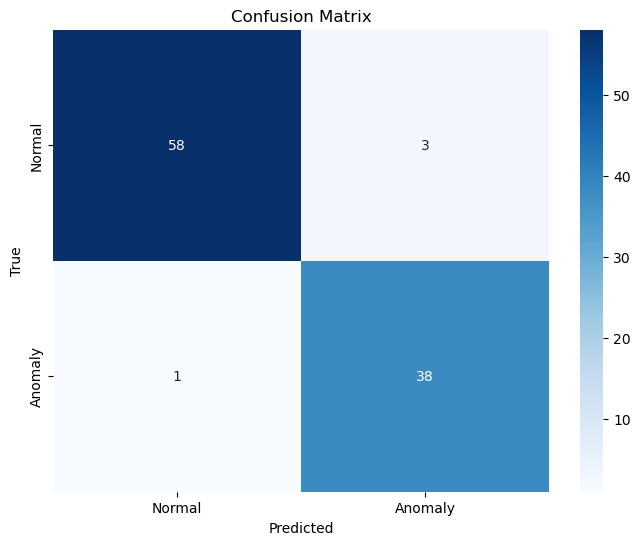

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix 계산
cm = confusion_matrix(true_labels, test_predictions)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


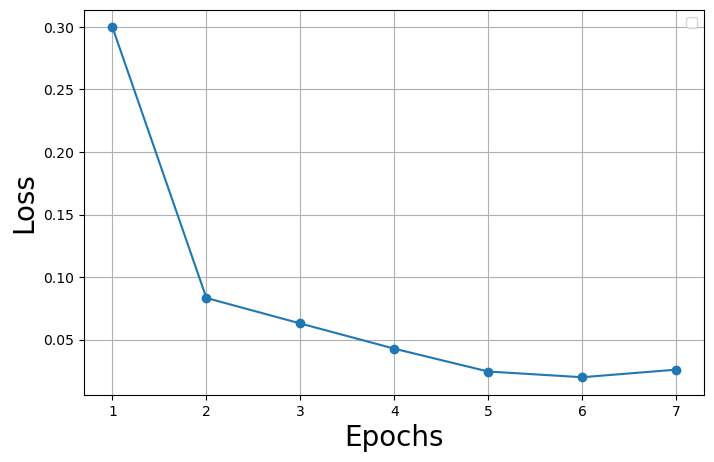

In [59]:
epochs = range(1, 8)

plt.figure(figsize=(8, 5))

plt.plot(epochs, losses, marker='o')

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.legend()
plt.grid(True)

plt.show()

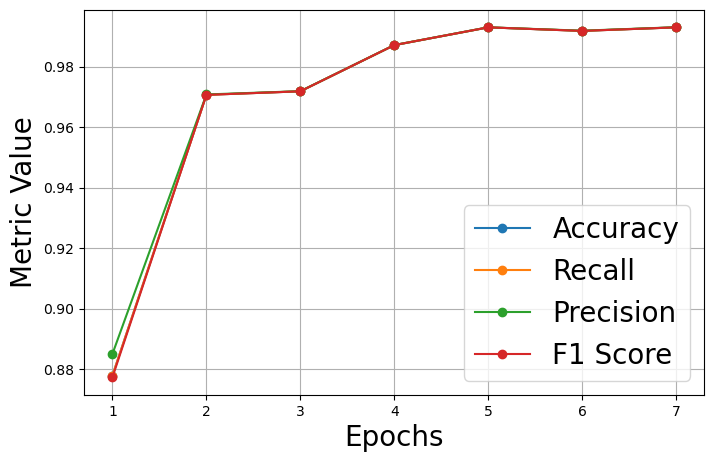

In [60]:
epochs = range(1, 8)

plt.figure(figsize=(8, 5))

plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, recalls, label='Recall', marker='o')
plt.plot(epochs, precisions, label='Precision', marker='o')
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Metric Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)

plt.show()